In [76]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import albumentations as A
import random
import logging
from glob import glob

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure logging for debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [106]:
# Define paths 
base_dir = Path('../datasets').resolve()
yolo_dir = Path('../yolo_cvat_v4').resolve()
train_img_dir = yolo_dir / 'images' / 'train'
train_lbl_dir = yolo_dir / 'labels' / 'train'
aug_img_dir = yolo_dir / 'images' / 'aug'
aug_lbl_dir = yolo_dir / 'labels' / 'aug'

# Create augmentation directories
for d in [aug_img_dir, aug_lbl_dir]:
    d.mkdir(parents=True, exist_ok=True)
logger.info("Augmentation directories created or verified.")

INFO:__main__:Augmentation directories created or verified.


In [77]:
# Function to clamp YOLO bounding boxes
def clamp_yolo_bbox(bbox):
    x_center, y_center, width, height = bbox[:4]
    # Calculate corner coordinates
    x_min = max(0, x_center - width / 2)
    y_min = max(0, y_center - height / 2)
    x_max = min(1, x_center + width / 2)
    y_max = min(1, y_center + height / 2)
    # Recompute width and height
    width = x_max - x_min
    height = y_max - y_min
    # Recompute centers
    x_center = x_min + width / 2
    y_center = y_min + height / 2
    # Return clamped bbox, preserving additional fields (e.g., class_id)
    return [x_center, y_center, width, height] + bbox[4:]

In [94]:
# Load the provided image and its label
image_path = train_img_dir / 'frame_IMG_6531_00014.jpg' 
label_path = train_lbl_dir / 'frame_IMG_6531_00014.txt'
image = cv2.imread(str(image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [95]:
# Load YOLO labels and clamp bounding boxes
with open(label_path, 'r') as f:
    labels = [line.strip().split() for line in f.readlines()]
class_labels = [int(label[0]) for label in labels]
bboxes = [list(map(float, label[1:])) for label in labels]  # [x_center, y_center, width, height]
bboxes = [clamp_yolo_bbox(bbox) for bbox in bboxes]  # Clamp bboxes

logger.info(f"Loaded image {image_path.name} with {len(bboxes)} bounding boxes.")

INFO:__main__:Loaded image frame_IMG_6531_00014.jpg with 4 bounding boxes.


# Original Image Visualization



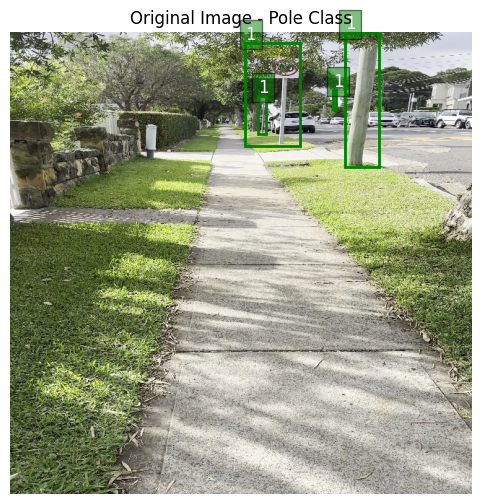

INFO:__main__:Displayed original image with bounding boxes.


In [96]:
def plot_image_with_bboxes(image, bboxes, class_labels, title=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    img_height, img_width = image.shape[:2]
    for bbox, cls in zip(bboxes, class_labels):
        x_center, y_center, width, height = bbox[:4]
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        w = width * img_width
        h = height * img_height
        rect = plt.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x_min, y_min - 5, str(cls), color='white', fontsize=12, 
                 bbox=dict(facecolor='green', alpha=0.5))
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_image_with_bboxes(image, bboxes, class_labels, title='Original Image - Pole Class')
logger.info("Displayed original image with bounding boxes.")

## Augmentation 1 - Partially Visible Objects (RandomCrop)



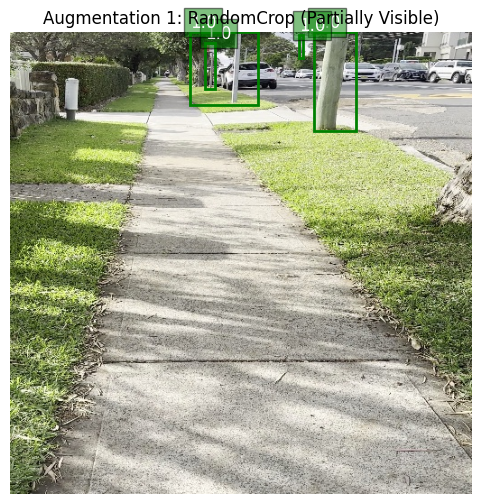

INFO:__main__:Applied RandomCrop: 4 boxes remain after cropping.


In [97]:
height, width = image.shape[:2]
crop_height = int(0.8 * height)
crop_width = int(0.8 * width)

transform = A.Compose([
    A.RandomCrop(height=crop_height, width=crop_width, p=1.0),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
aug_image = transformed['image']
aug_bboxes = transformed['bboxes']
aug_class_labels = transformed['class_labels']

plot_image_with_bboxes(aug_image, aug_bboxes, aug_class_labels, 
                       title='Augmentation 1: RandomCrop (Partially Visible)')
logger.info(f"Applied RandomCrop: {len(aug_bboxes)} boxes remain after cropping.")

## Augmentation 2 - Low Light Simulation (RandomBrightnessContrast)



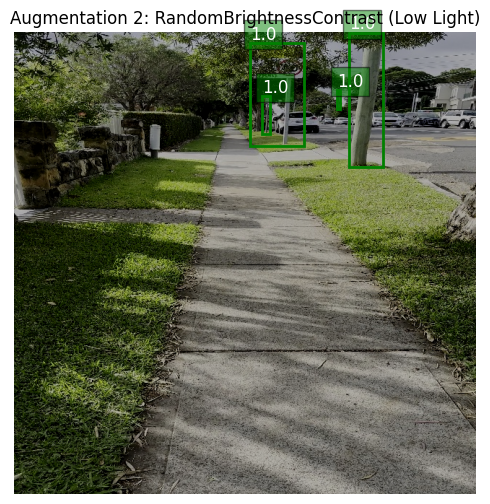

INFO:__main__:Applied RandomBrightnessContrast for low light simulation.


In [98]:
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.0), contrast_limit=(-0.3, 0.0), p=1.0),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
aug_image = transformed['image']
aug_bboxes = transformed['bboxes']
aug_class_labels = transformed['class_labels']

plot_image_with_bboxes(aug_image, aug_bboxes, aug_class_labels, 
                       title='Augmentation 2: RandomBrightnessContrast (Low Light)')
logger.info("Applied RandomBrightnessContrast for low light simulation.")

## Augmentation 3 - Occlusion (CoarseDropout)



/tmp/ipykernel_16116/445362502.py:2: UserWarning: Argument(s) 'max_holes, min_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, min_holes=4, max_height=int(0.1*height),


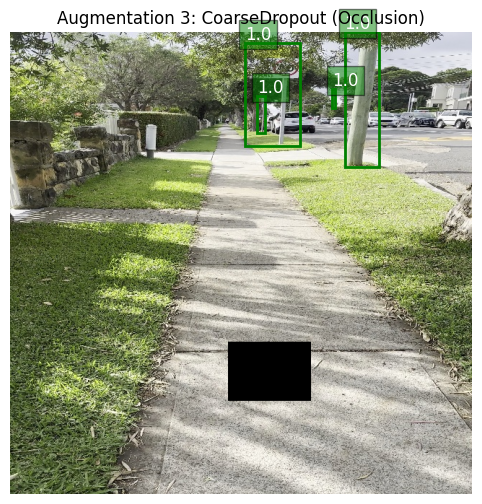

INFO:__main__:Applied CoarseDropout to simulate occlusion.


In [99]:
transform = A.Compose([
    A.CoarseDropout(max_holes=8, min_holes=4, max_height=int(0.1*height), 
                    max_width=int(0.1*width), fill_value=0, p=1.0),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
aug_image = transformed['image']
aug_bboxes = transformed['bboxes']
aug_class_labels = transformed['class_labels']

plot_image_with_bboxes(aug_image, aug_bboxes, aug_class_labels, 
                       title='Augmentation 3: CoarseDropout (Occlusion)')
logger.info("Applied CoarseDropout to simulate occlusion.")

## Augmentation 4 - Crowded Scenes (GridDropout)



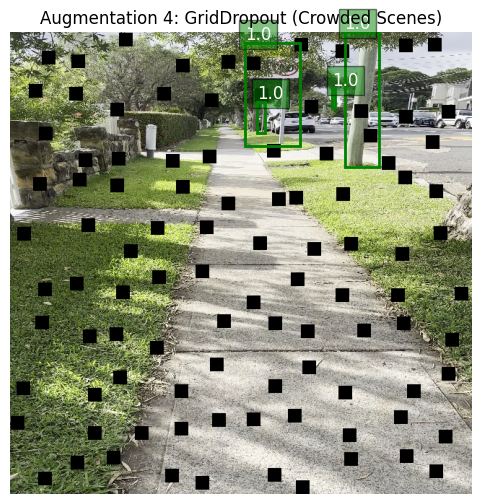

INFO:__main__:Applied GridDropout to simulate crowded scenes.


In [100]:
transform = A.Compose([
    A.GridDropout(ratio=0.3, p=1.0),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
aug_image = transformed['image']
aug_bboxes = transformed['bboxes']
aug_class_labels = transformed['class_labels']

plot_image_with_bboxes(aug_image, aug_bboxes, aug_class_labels, 
                       title='Augmentation 4: GridDropout (Crowded Scenes)')
logger.info("Applied GridDropout to simulate crowded scenes.")

## Augmentation 5 - Perspective Shift (ShiftScaleRotate)



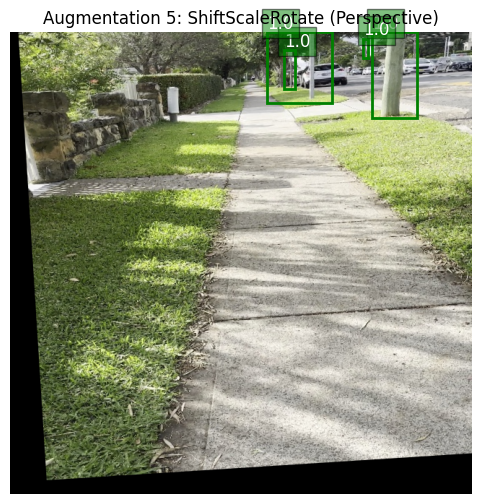

INFO:__main__:Applied ShiftScaleRotate for perspective variation.


In [101]:
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=1.0),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
aug_image = transformed['image']
aug_bboxes = transformed['bboxes']
aug_class_labels = transformed['class_labels']

plot_image_with_bboxes(aug_image, aug_bboxes, aug_class_labels, 
                       title='Augmentation 5: ShiftScaleRotate (Perspective)')
logger.info("Applied ShiftScaleRotate for perspective variation.")

In [107]:
# Define augmentation pipelines as a modular dictionary with consistent lambda functions
augmentations = {
    'partial_visible': lambda img: A.Compose([
        A.RandomCrop(height=int(0.8*img.shape[0]), width=int(0.8*img.shape[1]), p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    'low_light': lambda img: A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.0), contrast_limit=(-0.3, 0.0), p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    'occlusion': lambda img: A.Compose([
        A.CoarseDropout(max_holes=8, min_holes=4, max_height=int(0.1*img.shape[0]), 
                        max_width=int(0.1*img.shape[1]), fill_value=0, p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])),
    'crowded': lambda img: A.Compose([
        A.GridDropout(ratio=0.3, p=1.0),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
}

# Parameters
total_images = 2681  # Original dataset size
target_augmented = int(total_images * 0.3)  # At least 804
num_per_type = target_augmented // len(augmentations)  # ~201 per type
train_images = list(train_img_dir.glob('*.jpg'))

logger.info(f"Target: {target_augmented} augmented images. {num_per_type} per augmentation type.")

for aug_type in augmentations:
    np.random.shuffle(train_images)
    selected_images = train_images[:num_per_type]
    for img_path in selected_images:
        # Load image and label
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label_path = train_lbl_dir / f"{img_path.stem}.txt"
        with open(label_path, 'r') as f:
            labels = [line.strip().split() for line in f.readlines()]
        class_labels = [int(lbl[0]) for lbl in labels]
        bboxes = [list(map(float, lbl[1:])) for lbl in labels]
        
        # Clamp bounding boxes
        bboxes = [clamp_yolo_bbox(bbox) for bbox in bboxes]
        
        # Apply augmentation
        transform = augmentations[aug_type](image)  # Call lambda to get A.Compose
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_image = transformed['image']
        aug_bboxes = transformed['bboxes']
        aug_class_labels = transformed['class_labels']
        
        # Save with unique filename indicating augmentation type
        aug_img_path = aug_img_dir / f"{img_path.stem}_{aug_type}.jpg"
        aug_lbl_path = aug_lbl_dir / f"{img_path.stem}_{aug_type}.txt"
        cv2.imwrite(str(aug_img_path), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
        with open(aug_lbl_path, 'w') as f:
            for cls, bbox in zip(aug_class_labels, aug_bboxes):
                f.write(f"{cls} {' '.join(map(str, bbox))}\n")
    
    logger.info(f"Generated {num_per_type} augmented images for {aug_type}.")

INFO:__main__:Target: 804 augmented images. 201 per augmentation type.
INFO:__main__:Generated 201 augmented images for partial_visible.
INFO:__main__:Generated 201 augmented images for low_light.
/tmp/ipykernel_16116/3170610054.py:10: UserWarning: Argument(s) 'max_holes, min_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, min_holes=4, max_height=int(0.1*img.shape[0]),
INFO:__main__:Generated 201 augmented images for occlusion.
INFO:__main__:Generated 201 augmented images for crowded.


In [108]:
augmented_images = list(aug_img_dir.glob('*.jpg'))
num_augmented = len(augmented_images)
original_train_size = 1876
new_train_size = original_train_size + num_augmented
percent_increase = (num_augmented / total_images) * 100

logger.info(f"Augmented images generated: {num_augmented}")
logger.info(f"Original dataset: {total_images}, Original train: {original_train_size}")
logger.info(f"New train size: {new_train_size}, Increase: {percent_increase:.1f}% of total dataset")
assert num_augmented >= 804, "Did not meet +30% augmentation target."
logger.info("Augmentation complete. No label corruption detected. Samples stored in 'aug' directories.")

INFO:__main__:Augmented images generated: 804
INFO:__main__:Original dataset: 2681, Original train: 1876
INFO:__main__:New train size: 2680, Increase: 30.0% of total dataset
INFO:__main__:Augmentation complete. No label corruption detected. Samples stored in 'aug' directories.
